In [1]:
import os

# os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
import json
from pathlib import Path
from typing import Callable

import torch
from datasets import Dataset, DatasetDict, load_dataset
from numpy.typing import NDArray
from torch import Tensor, nn
from tqdm import tqdm
from transformers import EarlyStoppingCallback, Trainer, TrainingArguments
from ulid import ulid

from luminar.utils.training import LuminarTrainingConfig
from luminar.classifier import LuminarCNN
from luminar.utils import (
    ConvolutionalLayerSpec,
    compute_metrics,
    get_matched_datasets,
    get_pad_to_fixed_length_fn,
    save_model,
)

HF_TOKEN = (Path.home() / ".hf_token").read_text().strip()

### Encoder

In [3]:
# from luminar.encoder import LuminarEncoder


# encoder = LuminarEncoder()
# encoder.device = "cuda:0"

### Classifier

In [4]:
agent = "gpt_4o_mini"
other_agents = "gemma2_9b"
domain = "blog_authorship_corpus"

In [ ]:
feature_len = 128
seed = 42

pad_to_fixed_length: Callable[[NDArray], NDArray] = get_pad_to_fixed_length_fn(
    feature_len
)

In [6]:
datset_config_name = f"{domain}-fulltext"
dataset_split_name = f"human+{agent}+{other_agents}"
dataset: Dataset = (
    load_dataset(
        "liberi-luminaris/PrismAI-encoded-gpt2",
        datset_config_name,
        split=dataset_split_name,
        token=HF_TOKEN,
    )  # type: ignore
    .rename_column("label", "labels")
    .filter(
        lambda features: len(features) > 0,
        input_columns=["features"],
        num_proc=8,
    )
    .with_format("numpy", columns=["features"])
    .map(
        lambda features: {"features": pad_to_fixed_length(features)},
        input_columns=["features"],
        desc="Trimming & Padding Features",
        num_proc=8,
    )
)
dataset

Dataset({
    features: ['agent', 'id_sample', 'id_source', 'labels', 'length', 'features'],
    num_rows: 37864
})

In [7]:
datasets_matched, dataset_unmatched = get_matched_datasets(dataset, agent)
datasets_matched.set_format("torch", columns=["labels", "features"])
dataset_unmatched.set_format("torch", columns=["labels", "features"])

In [24]:
run_ulid = ulid()
config = LuminarTrainingConfig(
    feature_len=feature_len,
    feature_dim=(feature_len, 13),
    feature_type="intermediate_likelihoods",
    feature_model="gpt2",
    feature_selection="first",
    agent=agent,
    domain=domain,
    other_agents=other_agents,
    datset_config_name=other_agents,
    dataset_split_name="+".join(("human", agent, *other_agents)),
    #
    projection_dim=None,
    conv_layer_shapes=(
        ConvolutionalLayerSpec(32, 7),
        ConvolutionalLayerSpec(64, 5),
        ConvolutionalLayerSpec(128, 3),
    ),
    feed_forward_dim=(512, 32),
    #
    seed=seed,
    run_ulid=run_ulid,
)

training_args = config.training_arguments(
    len(datasets_matched["train"]),
    output_dir="../logs/hf/" + run_ulid,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=1024,
    num_train_epochs=10,
    learning_rate=5e-4,
    # lr_scheduler_type="reduce_lr_on_plateau",
    # lr_scheduler_kwargs={
    #     "mode": "min",
    #     "factor": 0.5,
    #     "patience": 3,
    #     "threshold": 0.001,
    #     "threshold_mode": "rel",
    #     # "cooldown": 1,
    #     "min_lr": 1e-6,
    # },
    # metric_for_best_model="accuracy",
    # greater_is_better=True,
    # torch_compile=True,
    # torch_compile_mode="reduce-overhead"
)

In [25]:
classifier = LuminarCNN(**config.asdict())
classifier.forward(
    torch.randn(32, feature_len, 13),
)

print(classifier)
print(
    "Parameters",
    "\n  cnn:",
    sum(
        param.numel()
        for param in classifier.cnn.parameters()
        if param.requires_grad
    ),
    "\n  classifier:",
    sum(
        param.numel()
        for param in classifier.classifier.parameters()
        if param.requires_grad
    ),
    "\n  total:",
    sum(param.numel() for param in classifier.parameters() if param.requires_grad),
)

LuminarCNN(
  (rescale): FeatureRescaler()
  (projection): Identity()
  (cnn): Sequential(
    (0): Conv1d(13, 32, kernel_size=(7,), stride=(1,), padding=(3,))
    (1): LeakyReLU(negative_slope=0.01)
    (2): Conv1d(32, 64, kernel_size=(5,), stride=(1,), padding=(2,))
    (3): LeakyReLU(negative_slope=0.01)
    (4): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (5): LeakyReLU(negative_slope=0.01)
  )
  (feed_forward): Sequential(
    (0): Linear(in_features=128, out_features=512, bias=True)
    (1): SiLU()
    (2): Linear(in_features=512, out_features=32, bias=True)
    (3): SiLU()
    (4): Flatten(start_dim=1, end_dim=-1)
  )
  (classifier): Linear(in_features=4096, out_features=1, bias=True)
  (criterion): BCEWithLogitsLoss()
)
Parameters 
  cnn: 37952 
  classifier: 4097 
  total: 124513


In [26]:
# conv_layer_spec = (
#     ConvolutionalLayerSpec(8, (7, 1)),
#     ConvolutionalLayerSpec(16, (7, 1)),
#     ConvolutionalLayerSpec(32, 7),
#     ConvolutionalLayerSpec(64, 5),
#     ConvolutionalLayerSpec(32, 3),
#     ConvolutionalLayerSpec(3, 3),
# )

# classifier = LuminarCNN2D(conv_layer_shapes=conv_layer_spec, **config)
# print(classifier)
# print("num. parameters:", sum(1 for p in classifier.parameters() if p.requires_grad))

In [27]:
trainer = Trainer(
    model=classifier,
    args=training_args,
    train_dataset=datasets_matched["train"],
    eval_dataset=datasets_matched["eval"],
    # data_collator=PaddingDataCollator(config["feature_dim"]),
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(10)],
)

In [28]:
trainer.train()
trainer._load_best_model()
classifier = trainer.model

metrics_eval = trainer.evaluate()
metrics_test = trainer.evaluate(datasets_matched["test"], metric_key_prefix="test")
metrics_unmatched = trainer.evaluate(dataset_unmatched, metric_key_prefix="unmatched")

path = save_model(trainer, config)

print("Evaluating on eval set")
metrics_eval = trainer.evaluate()
print(json.dumps(metrics_eval, indent=4))

print("Evaluating on test set")
metrics_test = trainer.evaluate(
    datasets_matched["test"],  # type: ignore
    metric_key_prefix="test",
)
print(json.dumps(metrics_test, indent=4))

print("Evaluating on unmatched set")
metrics_unmatched = trainer.evaluate(
    dataset_unmatched,  # type: ignore
    metric_key_prefix="unmatched",
)
print(json.dumps(metrics_unmatched, indent=4))

Step,Training Loss,Validation Loss,F1 Weighted,Accuracy,Roc Auc,F1 Human,F1 Ai,N Samples,F1 Weighted Median,Accuracy Median,Roc Auc Median,F1 Human Median,F1 Ai Median,Threshold Median
200,0.683000,0.678644,0.478364,0.545952,0.644762,0.290598,0.666130,914,0.590810,0.590810,0.644762,0.590810,0.590810,0.537713
240,0.667700,0.670121,0.532217,0.575492,0.667583,0.389937,0.674497,914,0.617068,0.617068,0.667583,0.617068,0.617068,0.588092
280,0.671500,0.657367,0.631395,0.637856,0.679371,0.680193,0.582598,914,0.625821,0.625821,0.679371,0.625821,0.625821,0.469676
320,0.651700,0.642181,0.631814,0.632385,0.695814,0.646316,0.617312,914,0.647702,0.647702,0.695814,0.647702,0.647702,0.488472
360,0.645800,0.636966,0.619332,0.626915,0.703532,0.673058,0.565605,914,0.658643,0.658643,0.703532,0.658643,0.658643,0.454453
400,0.623700,0.594273,0.670668,0.670678,0.752941,0.672470,0.668867,914,0.669584,0.669584,0.752941,0.669584,0.669584,0.497003
440,0.599600,0.612538,0.649752,0.665208,0.770600,0.576177,0.723327,914,0.689278,0.689278,0.770600,0.689278,0.689278,0.622223
480,0.583500,0.570717,0.696384,0.696937,0.778610,0.709339,0.683429,914,0.702407,0.702407,0.778610,0.702407,0.702407,0.475692
520,0.571700,0.563060,0.704120,0.707877,0.797040,0.737463,0.670777,914,0.717724,0.717724,0.797040,0.717724,0.717724,0.426672
560,0.569100,0.535189,0.731598,0.731947,0.810993,0.741288,0.721907,914,0.735230,0.735230,0.810993,0.735230,0.735230,0.471266


early stopping required metric_for_best_model, but did not find eval_loss so early stopping is disabled
early stopping required metric_for_best_model, but did not find eval_loss so early stopping is disabled


Evaluating on eval set
{
    "eval_loss": 0.4599413573741913,
    "eval_f1_weighted": 0.7724190768052096,
    "eval_accuracy": 0.7724288840262582,
    "eval_roc_auc": 0.8657307432642724,
    "eval_f1_human": 0.7739130434782608,
    "eval_f1_ai": 0.7709251101321586,
    "eval_n_samples": 914,
    "eval_f1_weighted_median": 0.7768052516411379,
    "eval_accuracy_median": 0.7768052516411379,
    "eval_roc_auc_median": 0.8657307432642724,
    "eval_f1_human_median": 0.7768052516411379,
    "eval_f1_ai_median": 0.7768052516411379,
    "eval_threshold_median": 0.48918724060058594,
    "eval_runtime": 5.2663,
    "eval_samples_per_second": 173.556,
    "eval_steps_per_second": 0.19,
    "epoch": 10.0
}
Evaluating on test set


early stopping required metric_for_best_model, but did not find eval_loss so early stopping is disabled


{
    "test_loss": 0.4543440341949463,
    "test_f1_weighted": 0.7816154023128263,
    "test_accuracy": 0.7816593886462883,
    "test_roc_auc": 0.8703268911729373,
    "test_f1_human": 0.7847147470398278,
    "test_f1_ai": 0.778516057585825,
    "test_n_samples": 1832,
    "test_f1_weighted_median": 0.7805676855895196,
    "test_accuracy_median": 0.7805676855895196,
    "test_roc_auc_median": 0.8703268911729373,
    "test_f1_human_median": 0.7805676855895196,
    "test_f1_ai_median": 0.7805676855895196,
    "test_threshold_median": 0.4840404987335205,
    "test_runtime": 7.0609,
    "test_samples_per_second": 259.459,
    "test_steps_per_second": 0.283,
    "epoch": 10.0
}
Evaluating on unmatched set


early stopping required metric_for_best_model, but did not find eval_loss so early stopping is disabled


{
    "unmatched_loss": 0.6830250024795532,
    "unmatched_f1_weighted": 0.6522281964629305,
    "unmatched_accuracy": 0.6583196046128501,
    "unmatched_roc_auc": 0.7118686018887167,
    "unmatched_f1_human": 0.7221701272605492,
    "unmatched_f1_ai": 0.5563636363636364,
    "unmatched_n_samples": 24280,
    "unmatched_f1_weighted_mean": 0.653477910639714,
    "unmatched_accuracy_mean": 0.6530065897858319,
    "unmatched_roc_auc_mean": 0.7118686018887167,
    "unmatched_f1_human_mean": 0.6975625516028288,
    "unmatched_f1_ai_mean": 0.5930541467420181,
    "unmatched_threshold_mean": 0.41250377893447876,
    "unmatched_n_samples_human": 14038,
    "unmatched_n_samples_ai": 10242,
    "unmatched_runtime": 41.2587,
    "unmatched_samples_per_second": 588.481,
    "unmatched_steps_per_second": 0.582,
    "epoch": 10.0
}


In [29]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.image import AxesImage
from numpy.typing import NDArray

cubehelix = sns.cubehelix_palette(as_cmap=True)


def visualize_features(features: NDArray, cmap=cubehelix, size=4) -> AxesImage:
    a = features.shape[0] / features.shape[1]
    h, w = (size, size * a) if a > 1 else (size, size / a)
    fig, ax = plt.subplots(figsize=(h, w))
    fig = ax.imshow(
        features,
        cmap=cmap,
        vmin=min(0.0, features.min()),
        vmax=max(1.0, features.max()),
        aspect="equal",
    )
    fig.axes.set_axis_off()
    plt.tight_layout()
    return fig


tensor(0)
torch.Size([128, 13])


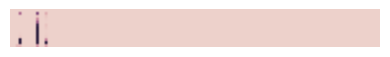

AttributeError: 'LuminarCNN' object has no attribute 'conv_layers'

In [30]:
sample = datasets_matched["test"][4]
print(sample["labels"])
features = sample["features"]
print(features.shape)
visualize_features(features.T)
plt.show()
with torch.inference_mode():
    conv = (
        classifier.conv_layers(features.T.unsqueeze(0).to("cuda"))
        .cpu()
        .detach()[0].T
    )
    print(conv.shape)
    visualize_features(conv.clip(0, 1).numpy().T)
    plt.show()

    ff = classifier.projection[:-1](conv.unsqueeze(0).to("cuda")).cpu().detach()[0]
    print(ff.shape)
    visualize_features(ff.numpy().T)
    plt.show()

In [ ]:
sample = datasets_matched["test"][-1]
print(sample["labels"])
features = sample["features"]
print(features.shape)
visualize_features(features.T)
plt.show()

with torch.inference_mode():
    conv = (
        classifier.conv_layers[:-1](features.T.unsqueeze(0).to("cuda"))
        .cpu()
        .detach()[0]
        .T
    )
    print(conv.shape)
    visualize_features(conv.clip(0, 1).numpy().T)
    plt.show()

    ff = classifier.projection[:-1](conv.unsqueeze(0).to("cuda")).cpu().detach()[0]
    print(ff.shape)
    visualize_features(ff.numpy().T)
    plt.show()

In [ ]:
raise RuntimeError()

In [ ]:
import json

print(json.dumps(scores, indent=4))
with open("../logs/luminar/gpt2_first_128-3_epochs.json", "w") as f:
    json.dump(scores, f, indent=4)

In [ ]:
datasets = {}
for subset in [
    "blog_authorship_corpus",
    "student_essays",
    "cnn_news",
    "euro_court_cases",
    "house_of_commons",
    "arxiv_papers",
    "gutenberg_en",
    "en",
    "bundestag",
    "spiegel_articles",
    "gutenberg_de",
    "de",
]:
    datset_config_name = f"{subset}-fulltext"
    datasets[datset_config_name] = load_dataset(
        "liberi-luminaris/PrismAI-encoded-gpt2",
        datset_config_name,
        token=HF_TOKEN,
        split="human+gpt_4o_mini",
    )

In [ ]:
dataset = load_dataset(
    "liberi-luminaris/PrismAI-fulltext", "cnn_news", split="human+gpt_4o_mini"
)
dataset_human = dataset.filter(lambda sample: sample["agent"] == "human")
source_ids = set(
    dataset_human.shuffle(seed=42).take(len(dataset_human) // 10 * 8)["id_source"]
)
dataset_train = dataset.filter(lambda sample: sample["id_source"] in source_ids)

In [ ]:
datasets_truncated = {}
for datset_config_name, dataset in datasets.items():
    datasets_truncated[datset_config_name] = dataset.with_format(
        "numpy", columns=["features"], output_all_columns=True
    ).map(
        lambda batch: {"features": batch["features"][:, :256]},
        batched=True,
    )

In [ ]:
datasets_considered = {
    key: value
    for key, value in datasets_truncated.items()
    if not key.startswith("de-") and not key.startswith("en-")
}

In [ ]:
import pandas as pd

domains = [
    "Web Blogs",
    "Essays",
    "CNN",
    "ECHR",
    "HoC",
    "arXiv",
    "Gutenberg$_{en}$",
    "Bundestag$_{de}$",
    "Spiegel$_{de}$",
    "Gutenberg$_{de}$",
    "All$_{en}$",
    "All$_{de}$",
]
name_map = {
    "blog_authorship_corpus": "Web Blogs",
    "student_essays": "Essays",
    "cnn_news": "CNN",
    "euro_court_cases": "ECHR",
    "house_of_commons": "HoC",
    "arxiv_papers": "arXiv",
    "gutenberg_en": "Gutenberg$_{en}$",
    "bundestag": "Bundestag$_{de}$",
    "spiegel_articles": "Spiegel$_{de}$",
    "gutenberg_de": "Gutenberg$_{de}$",
    "en": "All$_{en}$",
    "de": "All$_{de}$",
}

results = [
    {"domain": name_map[key.split("-", 1)[0]]}
    | {
        "f1": value["f1"],
        "acc": value["accuracy"],
        "auroc": value["auroc"],
    }
    for key, value in scores.items()
]
metric_df = (
    pd.DataFrame(results)
    .set_index("domain")
    .sort_index(key=lambda x: list(map(domains.index, x)))
)
print(metric_df.to_latex(float_format="%.3f", index=True))
metric_df

In [ ]:
# def run_detector(
#     detector: DetectorABC, datasets: dict[str, DatasetDict]
# ) -> dict[str, float]:
#     scores = {}
#     for config_name, ds in tqdm(datasets.items(), desc="Predicting on Datasets"):
#         dataset: Dataset = ds["test"].map(
#             detector.tokenize,
#             input_columns=["text"],
#             batched=True,
#             batch_size=1024,
#             desc="Tokenizing",
#         )
#         dataset = dataset.sort("length")
#         dataset = dataset.map(
#             detector.process,
#             batched=True,
#             batch_size=128,
#             desc="Predicting",
#         )

#         dataset_np = dataset.select_columns(["prediction", "label"]).with_format(
#             "numpy"
#         )

#         acc, f1, auroc = get_scores(dataset_np["label"], dataset_np["prediction"])
#         scores[config_name] = {"accuracy": acc, "f1": f1, "auroc": auroc}

#         acc, f1, auroc = get_scores(
#             dataset_np["label"],
#             dataset_np["prediction"],
#             calibrated=True,
#         )
#         scores[config_name] |= {
#             "accuracy_calibrated": acc,
#             "f1_calibrated": f1,
#             "auroc_calibrated": auroc,
#         }
#     return scores


In [ ]:
# def evaluate(model: LuminarClassifier, datasets: dict[str, DatasetDict]) -> dict:
#     scores = {}
#     for config_name, dataset in tqdm(datasets.items(), desc="Evaluating", leave=False):
#         ds = (
#             dataset["test"]
#             .with_format("torch", ["features"])
#             .map(model.process, batched=True, batch_size=32, desc="Predicting")
#         )
#         dataset_np = ds.select_columns(["prediction", "label"]).with_format("numpy")

#         acc, f1, auroc = get_scores(dataset_np["label"], dataset_np["prediction"])
#         scores[config_name] = {
#             "accuracy": acc,
#             "f1": f1,
#             "auroc": auroc,
#         }

#         acc, f1, auroc = get_scores(
#             dataset_np["label"],
#             dataset_np["prediction"],
#             calibrated=True,
#         )
#         scores[config_name] |= {
#             "accuracy_calibrated": acc,
#             "f1_calibrated": f1,
#             "auroc_calibrated": auroc,
#         }

#     return scores